In [7]:
### IMPORTS ###
%load_ext autoreload
%autoreload 2
import sys, os

# Project-specific imports
sys.path.append(os.path.abspath("src"))
from pathlib import Path
from src.train import Trainer
from utils import save_model, set_global_seed
from utils_visualization import plot_metrics, load_history, visualize_slices
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
EXPERIMENT = "exp23_nnunet"
BASE_DIR = Path("results") / EXPERIMENT
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
MODEL_DIR = BASE_DIR / "models"
LOG_DIR = BASE_DIR / "logs"
PRED_DIR         = BASE_DIR / "predictions"

Loading history from results/exp23_nnunet/logs/history_081.json


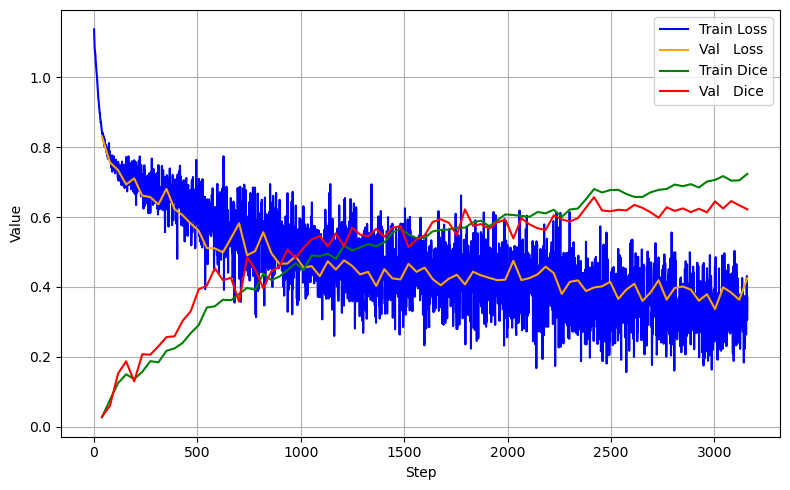

In [3]:
### PLOTTING ###
from pathlib import Path

# Automatically pick the latest history file:
history_files = sorted(
    Path(LOG_DIR).glob("history_*.json"),
    key=lambda p: int(p.stem.split('_')[-1])  # sort by epoch number in filename
)
latest_history = history_files[-1]
print(f"Loading history from {latest_history}")
history = load_history(str(latest_history))

# Plot curves
plot_metrics(
    history,
    metrics=[
        ("train",      "loss", "Train Loss",       "blue"),
        ("validation", "loss", "Val   Loss",       "orange"),
        ("train",      "dice", "Train Dice",      "green"),
        ("validation", "dice", "Val   Dice",      "red"),
    ]
)


In [4]:
# Extract summary into DataFrame
records = []
for step_str in history["validation"]["dice"]:
    step = int(step_str)
    records.append({
        "step": step,
        "train_loss": history["train"]["loss"].get(step_str),
        "val_loss":   history["validation"]["loss"].get(step_str),
        "train_dice": history["train"]["dice"].get(step_str),
        "val_dice":   history["validation"]["dice"].get(step_str),
        "train_dice_class1": history["train"].get("dice_class1", {}).get(step_str),
        "val_dice_class1":   history["validation"].get("dice_class1", {}).get(step_str),
        "train_dice_class2": history["train"].get("dice_class2", {}).get(step_str),
        "val_dice_class2":   history["validation"].get("dice_class2", {}).get(step_str),
    })
df = pd.DataFrame(records).sort_values("step")

# Final metrics
final = df.iloc[-1]
print(
    f"At globalstep {final.step}:\n"
    f"Train Loss = {final.train_loss:.3f}, Val Loss = {final.val_loss:.3f}\n"
    f"Train Avg Dice = {final.train_dice:.3f}, Val Avg Dice = {final.val_dice:.3f}\n"
    f"Train Class1 Dice = {final.train_dice_class1:.3f}, Val Class1 Dice = {final.val_dice_class1:.3f}\n"
    f"Train Class2 Dice = {final.train_dice_class2:.3f}, Val Class2 Dice = {final.val_dice_class2:.3f}\n"
)



At globalstep 3159.0:
Train Loss = 0.369, Val Loss = 0.425
Train Avg Dice = 0.724, Val Avg Dice = 0.622
Train Class1 Dice = 0.667, Val Class1 Dice = 0.619
Train Class2 Dice = 0.780, Val Class2 Dice = 0.625



In [5]:
# Find the step with the best validation Dice score
best_idx = df["val_dice"].idxmax()
best = df.loc[best_idx]

print(
    f"Best model was at globalstep {best.step}:\n"
    f"Train Loss = {best.train_loss:.3f}, Val Loss = {best.val_loss:.3f}\n"
    f"Train Avg Dice = {best.train_dice:.3f}, Val Avg Dice = {best.val_dice:.3f}\n"
    f"Train Class1 Dice = {best.train_dice_class1:.3f}, Val Class1 Dice = {best.val_dice_class1:.3f}\n"
    f"Train Class2 Dice = {best.train_dice_class2:.3f}, Val Class2 Dice = {best.val_dice_class2:.3f}\n"
)


Best model was at globalstep 2418.0:
Train Loss = 0.439, Val Loss = 0.398
Train Avg Dice = 0.680, Val Avg Dice = 0.657
Train Class1 Dice = 0.624, Val Class1 Dice = 0.670
Train Class2 Dice = 0.736, Val Class2 Dice = 0.644



In [ ]:
all_hist = []
for fold in range(5):
    logs = sorted((BASE_DIR/f"fold{fold}/logs").glob("history_*.json"))
    # pick the last (or best) file
    hist = json.load(logs[-1].open())
    # extract final dice
    final_step = max(hist["validation"]["dice"], key=lambda k: int(k))
    final_dice = hist["validation"]["dice"][final_step]
    all_hist.append(float(final_dice))

# Compute mean ± std_ across folds
mean_dice = sum(all_hist)/len(all_hist)
std_dice  = pd.Series(all_hist).std()

print(f"5‑fold validation Dice: {mean_dice:.3f} ± {std_dice:.3f}")

Label class distribution: (1740353, 10767, 18352)
Prediction class distribution: (1744258, 9802, 15412)


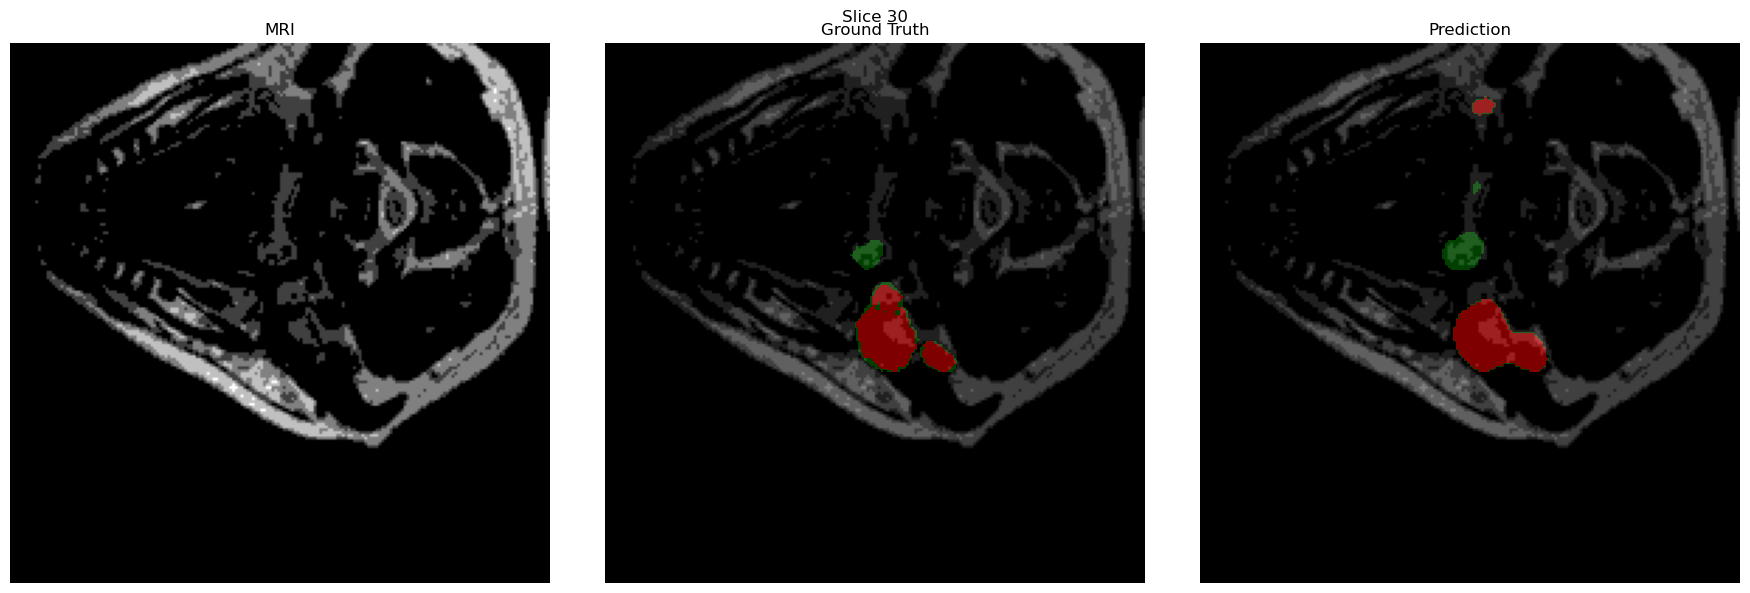

In [6]:
### VISUALIZATION ###
image_path = "results/exp23_nnunet/predictions/image_2.nii.gz"
label_path = "results/exp23_nnunet/predictions/label_2.nii.gz"
prediction_path = "results/exp23_nnunet/predictions/prediction_2.nii.gz"

# Visualize a specific slice (e.g., slice 50)
visualize_slices(image_path, label_path, prediction_path, slice_idx=30)
